In [1]:
import os 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import backend as K
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.chdir("../../")

In [2]:
print(os.getcwd())

e:\medsoft\Learning\ai_in_medicine


In [3]:

from helpers.helpers.ai.io import get_train_generator, get_test_and_valid_generator

IMAGE_DIR  = "data/nih/images-small/"
LABELS = ['Cardiomegaly', 
        'Emphysema', 
        'Effusion', 
        'Hernia', 
        'Infiltration', 
        'Mass', 
        'Nodule', 
        'Atelectasis',
        'Pneumothorax',
        'Pleural_Thickening', 
        'Pneumonia', 
        'Fibrosis', 
        'Edema', 
        'Consolidation']
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df =  pd.read_csv("data/nih/test-small.csv")


train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", LABELS)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", LABELS)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


e:\medsoft\Learning\ai_in_medicine\env\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


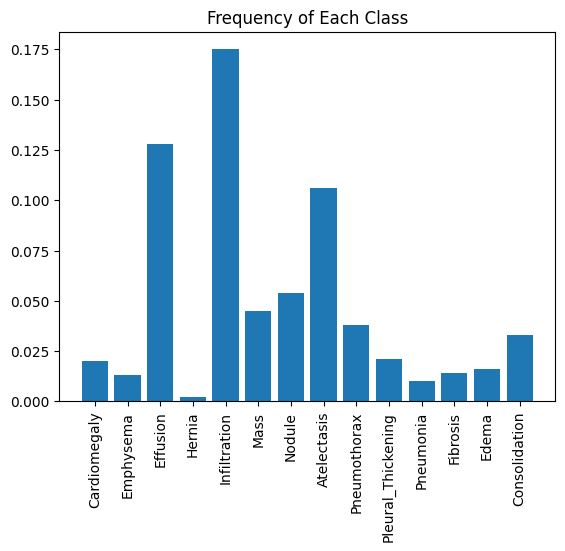

In [4]:
plt.xticks(rotation=90)
plt.bar(x=LABELS, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

In [5]:
from helpers.helpers.ai.loss import compute_class_freqs
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

In [6]:
freq_neg

array([0.98 , 0.987, 0.872, 0.998, 0.825, 0.955, 0.946, 0.894, 0.962,
       0.979, 0.99 , 0.986, 0.984, 0.967])

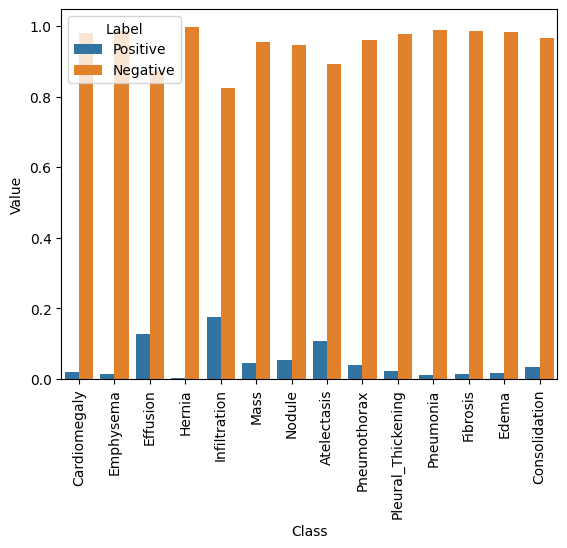

In [11]:
data = pd.DataFrame({"Class": LABELS, "Label": "Positive", "Value": freq_pos})
rows_data = [{"Class": LABELS[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)]

data = pd.concat([data, pd.DataFrame(rows_data)],  ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [12]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

<Axes: xlabel='Class', ylabel='Value'>

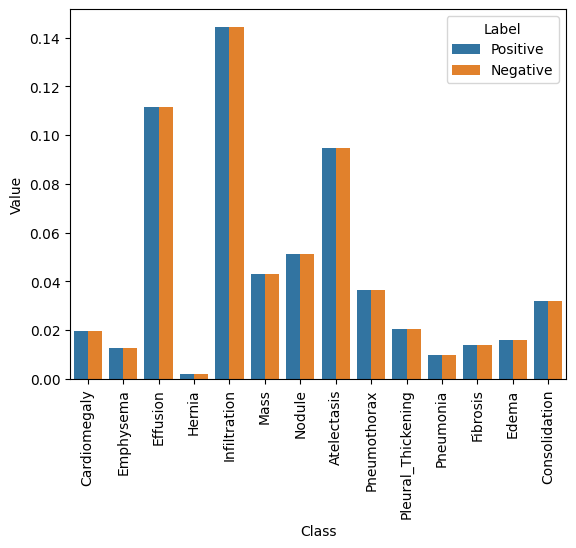

In [13]:
data = pd.DataFrame({"Class": LABELS, "Label": "Positive", "Value": pos_contribution})
rows_data = [{"Class": LABELS[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)]
data = pd.concat([data, pd.DataFrame(rows_data)],  ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [ ]:
from helpers.helpers.ai.loss import get_weighted_loss

See the implentation of `get_weighted_loss` for more details